In [1]:
# added to remove some of the performance warnings
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

from argparse import ArgumentParser

import numpy as np
from lal import GreenwichMeanSiderealTime
from gwbench import Network

In [2]:
np.set_printoptions(linewidth=200)

parser = ArgumentParser()
parser.add_argument('--derivs', type = str, help = 'Specify wich differentiation method to use: [num, sym].', default = 'num')

parser.add_argument("-f", required=False)

_StoreAction(option_strings=['-f'], dest='f', nargs=None, const=None, default=None, type=None, choices=None, required=False, help=None, metavar=None)

In [3]:
# choose between numeric or symbolic derivatives ['num', 'sym']
derivs = parser.parse_args().derivs

# user's choice: waveform to use
wf_model_name = 'lal_bbh_ecc'
wf_other_var_dic = {'approximant':'SpinTaylorF2Ecc'}
# wf_other_var_dic = {'approximant':'TaylorF2ecc'}

user_waveform = None

In [4]:
# example detector location defined by user (keep it empty if the detector tech is not custom defined )
user_locs = {}

# example detector psd defined by the user (keep it empty if the detector tech is not custom defined )
user_psds = {}

# user's choice: with respect to which parameters to take derivatives for the Fisher analysis
# deriv_symbs_string = 'Mc eta chi1z chi2z DL tc phic e0 ra dec psi iota'
deriv_symbs_string = 'Mc eta chi1z chi2z DL tc phic e0 ra dec psi iota'

# user's choice: convert derivatives to cos or log for specific variables
conv_cos = ('dec', 'iota')
conv_log = ('Mc', 'DL')

# if numeric  derivatives, user's decision, 1 for True, 0 for False
use_rot = 0

# calculate SNRs, error matrices, and errors only for the network (If 1, will calculate the mentioned values only for network otherwise
# will calculate it for detectors as well as network)
only_net = 1

# number of cores to use for parallelize of the calc_det_responses_derivs
num_cores = None

In [5]:
# options for numeric derivative calculation
# user's choice: switch particular partial derivatives to be analytical, options = [DL,tc,phic,ra,dec,psi]
ana_deriv_symbs_string = None

# choose numdifftools parameters for numerical derivatives
step = 1e-9
method = 'central'
order = 2

# only relevant for symbolic derivatives
gen_derivs = None

In [6]:
# 'user-tec_user-loc' is for custom define detector and its location
network_spec1 = ['ET_V']
network_spec2 = ['CE-40_H']
network_spec3 = ['CE-40_L']


print('network spec: ', network_spec1, network_spec2, network_spec3)
print()

network spec:  ['ET_V'] ['CE-40_H'] ['CE-40_L']



In [7]:
import numpy as np
import astropy as ap
from gwbench.utils import MTsun
from gwbench.basic_relations import DL_of_z_ap_cosmo, f_isco_Msolar, Mc_of_M_eta, eta_of_q

# Load the data from the CSV file
loaded_data = np.loadtxt("Injdata_spins_TF2VsTF2ecc_500realz.csv", delimiter=",", skiprows=1)

# Access columns individually
data_Mc = loaded_data[:, 0]
data_totalmass = loaded_data[:, 1]
data_chi1z = loaded_data[:, 2]
data_chi2z = loaded_data[:, 3]
data_ecc = loaded_data[:, 4]
data_eta = loaded_data[:, 5]
data_DL = loaded_data[:, 6]
data_iota = loaded_data[:, 7]
data_ra = loaded_data[:, 8]
data_dec = loaded_data[:, 9]
data_psi = loaded_data[:, 10]
data_z = loaded_data[:, 11]


In [9]:
# Store SNRs and errors for each set of parameters
snrs_ET = []
snrs_CEH = []
snrs_CEL = []

Fish_ET = []
Fish_CEH = []
Fish_CEL = []

realizations = 500

for i in range(realizations):
    inj_params = {
        'Mc': data_Mc[i],
        # 'Mc': (total_mass[i]*(eta[i])**0.6)*(1+z[i]),
        'e0': data_ecc[i],
        'eta': data_eta[i],
        'chi1x': 0.,
        'chi1y': 0.,
        'chi1z': data_chi1z[i],
        'chi2x': 0.,
        'chi2y': 0.,
        'chi2z': data_chi2z[i],
        'DL': data_DL[i],
        'tc': 0.0,
        'phic': 0.0,
        'iota': data_iota[i],
        'ra': data_ra[i],
        'dec': data_dec[i],
        'psi': data_psi[i],
        'gmst0': 0.,
        'z': data_z[i],
    }

    
    # choose f_low acc to the detector in the network
    f_hi = f_isco_Msolar(data_totalmass[i]) #doubt, whether to take the redshift here or not?
    df = 2.**-4
    
    # Detector#1
    f_lo_ET = 3
    f_ET = np.arange(f_lo_ET, f_hi + df, df)

    # Detector#2
    f_lo_CEH = 5
    f_CEH = np.arange(f_lo_CEH, f_hi + df, df)

    # Detector#3
    f_lo_CEL = 5
    f_CEL = np.arange(f_lo_CEL, f_hi + df, df)

    # Initialize the Network object
    net1 = Network(network_spec1, logger_name='detectorET', logger_level='INFO')
    net2 = Network(network_spec2, logger_name='detectorCEH', logger_level='INFO')
    net3 = Network(network_spec3, logger_name='detectorCEL', logger_level='INFO')
    

    # Set network variables for the current injection parameters    
    net1.set_net_vars(
        wf_model_name=wf_model_name,
        wf_other_var_dic=wf_other_var_dic,
        user_waveform=user_waveform,
        f=f_ET,
        inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos,
        conv_log=conv_log,
        use_rot=use_rot,
        user_locs=user_locs,
        user_psds=user_psds,
        ana_deriv_symbs_string=ana_deriv_symbs_string
    )


    net2.set_net_vars(
        wf_model_name=wf_model_name,
        wf_other_var_dic=wf_other_var_dic,
        user_waveform=user_waveform,
        f=f_CEH,
        inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos,
        conv_log=conv_log,
        use_rot=use_rot,
        user_locs=user_locs,
        user_psds=user_psds,
        ana_deriv_symbs_string=ana_deriv_symbs_string
    )


    net3.set_net_vars(
        wf_model_name=wf_model_name,
        wf_other_var_dic=wf_other_var_dic,
        user_waveform=user_waveform,
        f=f_CEL,
        inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos,
        conv_log=conv_log,
        use_rot=use_rot,
        user_locs=user_locs,
        user_psds=user_psds, 
        ana_deriv_symbs_string=ana_deriv_symbs_string
    )

    net1.calc_errors(only_net=only_net, derivs=derivs, step=step, method=method, order=order, gen_derivs=gen_derivs, num_cores=num_cores)
    net2.calc_errors(only_net=only_net, derivs=derivs, step=step, method=method, order=order, gen_derivs=gen_derivs, num_cores=num_cores)
    net3.calc_errors(only_net=only_net, derivs=derivs, step=step, method=method, order=order, gen_derivs=gen_derivs, num_cores=num_cores)
    # snr_ET, errs_ET, cov_ET, fisher_ET, inv_err_ET = net1.get_snrs_errs_cov_fisher_inv_err_for_key(key=network_spec1[0])

    snrs_ET.append(net1.snr)
    snrs_CEH.append(net2.snr)
    snrs_CEL.append(net3.snr)

    Fish_ET.append(net1.fisher)
    Fish_CEH.append(net2.fisher)
    Fish_CEL.append(net3.fisher)

2024-09-18 23:13:12,278 - detectorET - INFO : PSDs, antenna patterns, and LPFs loaded.
2024-09-18 23:13:12,279 - detectorET - INFO : Calculate numeric derivatives of detector responses.
2024-09-18 23:13:12,279 - detectorET - INFO :    ET_V
2024-09-18 23:13:12,412 - detectorET - INFO : Numeric derivatives of detector responses calculated.
2024-09-18 23:13:12,413 - detectorET - INFO : SNRs calculated.
2024-09-18 23:13:12,413 - detectorET - INFO : Calculate errors (Fisher & cov matrices).
2024-09-18 23:13:12,413 - detectorET - INFO :    ET_V
2024-09-18 23:13:12,441 - detectorET - INFO : Sky areas calculated.
2024-09-18 23:13:12,441 - detectorET - INFO : Errors calculated.
2024-09-18 23:13:12,445 - detectorCEH - INFO : PSDs, antenna patterns, and LPFs loaded.
2024-09-18 23:13:12,446 - detectorCEH - INFO : Calculate numeric derivatives of detector responses.
2024-09-18 23:13:12,446 - detectorCEH - INFO :    CE-40_H
2024-09-18 23:13:12,563 - detectorCEH - INFO : Numeric derivatives of detect

In [13]:
snrs_ET =  np.array(snrs_ET)
snrs_CEH =  np.array(snrs_CEH)
snrs_CEL =  np.array(snrs_CEL)

Netsnrscheck = ((snrs_ET**2)+(snrs_CEH**2)+(snrs_CEL**2))**(1/2)

# print(Netsnrscheck)
print(len(Fish_ET))

500


In [16]:
import numpy as np

# Threshold for the condition number
condition_number_threshold = 1e15

# Lists to store valid realizations of chirp mass, errors, and SNRs
valid_Mc = []
valid_M = []
valid_eta = []
valid_DL = []
valid_e0 = []
valid_chi1z = []
valid_chi2z = []

valid_errors_Mc = []
valid_errors_eta = []
valid_errors_DL = []
valid_errors_e0 = []
valid_errors_chi1z = []
valid_errors_chi2z = []

valid_Netsnrs = []

# Lists for rejected cases
rejected_Mc = []
rejected_eta = []
rejected_DL = []
rejected_e0 = []
rejected_iota = []
rejected_Netsnrs = []

for i in range(realizations):
    # Compute the Fisher matrix by summing contributions from different detectors
    Fish_matrix = Fish_ET[i] + Fish_CEL[i] + Fish_CEH[i]
    
    # Compute eigenvalues of the Fisher matrix
    eigenvalues = np.linalg.eigvals(Fish_matrix)
    
    # Calculate condition number as ratio of max to min eigenvalues
    max_eigenvalue = np.max(np.abs(eigenvalues))
    min_eigenvalue = np.min(np.abs(eigenvalues))
    
    condition_number = max_eigenvalue / min_eigenvalue
    
    # Compute the combined SNR
    Netsnrs = (((snrs_ET[i])**2) + ((snrs_CEH[i])**2) + ((snrs_CEL[i])**2))**(1/2)
    
    # Check if condition number is within the acceptable threshold
    if condition_number < condition_number_threshold:
        try:
            # Compute the covariance matrix by inverting the Fisher matrix
            cov_matrix = np.linalg.inv(Fish_matrix)
            
            # Extract diagonal elements and compute standard errors
            errors = np.sqrt(np.diag(cov_matrix))
            
            # Store specific parameter errors and chirp mass to the lists
            valid_errors_Mc.append(errors[0])
            valid_errors_eta.append(errors[1])
            valid_errors_chi1z.append(errors[2])
            valid_errors_chi2z.append(errors[3])
            valid_errors_DL.append(errors[4])
            valid_errors_e0.append(errors[7])
            
            valid_Mc.append(data_Mc[i])
            valid_M.append(data_totalmass[i])
            valid_eta.append(data_eta[i])
            valid_DL.append(data_DL[i])
            valid_e0.append(data_ecc[i])
            valid_chi1z.append(data_chi1z[i])
            valid_chi2z.append(data_chi2z[i])
            
            valid_Netsnrs.append(Netsnrs)
            
        except np.linalg.LinAlgError:
            print(f"Singular matrix encountered at realization {i}. Case skipped.")
    else:
        # print the rejected cases
        print(f"High condition number ({condition_number:.2e}) at realization {i}. Case rejected.")
        
        # Store the rejected parameters and SNRs
        rejected_Mc.append(data_Mc[i])
        rejected_eta.append(data_eta[i])
        rejected_DL.append(data_DL[i])
        rejected_e0.append(data_ecc[i])
        rejected_iota.append(data_iota[i])
        rejected_Netsnrs.append(Netsnrs)

# print the rejected parameters and SNRs
for i in range(len(rejected_Mc)):
    print(f"Rejected Case {i}: Mc={rejected_Mc[i]}, eta={rejected_eta[i]}, DL={rejected_DL[i]}, e0={rejected_e0[i]}, iota={rejected_iota[i]}, SNR={rejected_Netsnrs[i]}")


High condition number (2.50e+15) at realization 13. Case rejected.
High condition number (9.46e+16) at realization 50. Case rejected.
High condition number (2.80e+16) at realization 51. Case rejected.
High condition number (1.06e+15) at realization 52. Case rejected.
High condition number (1.77e+15) at realization 69. Case rejected.
High condition number (1.92e+15) at realization 75. Case rejected.
High condition number (1.43e+15) at realization 89. Case rejected.
High condition number (5.14e+16) at realization 90. Case rejected.
High condition number (1.19e+15) at realization 94. Case rejected.
High condition number (1.56e+15) at realization 97. Case rejected.
High condition number (2.00e+15) at realization 112. Case rejected.
High condition number (1.01e+15) at realization 114. Case rejected.
High condition number (1.66e+15) at realization 126. Case rejected.
High condition number (9.75e+15) at realization 128. Case rejected.
High condition number (7.00e+15) at realization 135. Case 

In [17]:
print(len(valid_errors_Mc))
print(len(valid_errors_eta))

print(len(valid_Mc))

print(len(valid_Netsnrs))

456
456
456
456


In [19]:
# Stacking into a 2D array, each column is a different variable
# data = np.column_stack((valid_errors_Mc, valid_errors_eta, valid_errors_chi1z, valid_errors_chi2z, valid_errors_DL, valid_errors_e0))
valid_data = np.column_stack((valid_Mc, valid_M, valid_eta, valid_chi1z, valid_chi2z, valid_DL, valid_e0))
# valid_snrs = np.column_stack((valid_snr))

# Save the array to a CSV file
# np.savetxt("errors_Mcetachi1zchi2zDLe0_STF2ecc_500realz.csv", data, delimiter=",", header="Mc,eta,chi1z,chi2z,DL,e0", comments="")
np.savetxt("validInj_STF2Ecc_McMetachi1zchi2zDLe0_500realz.csv", valid_data, delimiter=",", header="Mc,M,eta,chi1z,chi2z,DL,e0", comments="")
# np.savetxt("validSNR_McMetaDLe0.csv", valid_snrs, delimiter=",", header="Mc,M,eta,DL,e0", comments="")

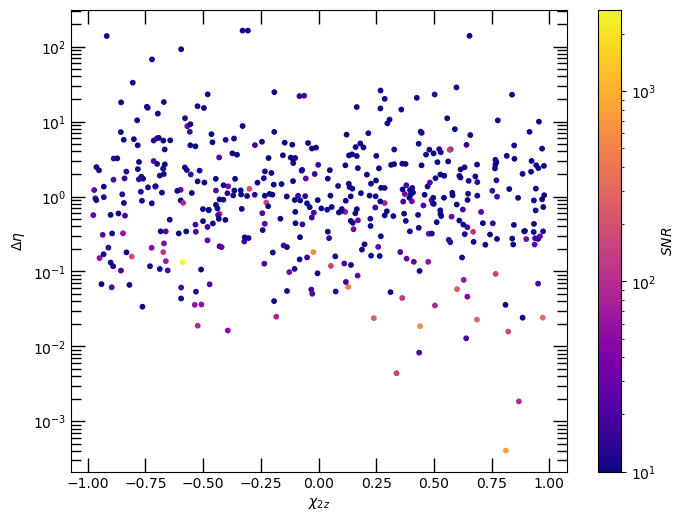

In [51]:
# SNR VS e0 vS q scatter plot
import numpy as np

# Load the data from the CSV file
dataSTF2ecc = np.loadtxt("errors_Mcetachi1zchi2zDLe0_STF2ecc_500realz.csv", delimiter=",", skiprows=1)
# dataTF2 = np.loadtxt("errors_McetaDL_TF2_100realz.csv", delimiter=",", skiprows=1)
Injvalid = np.loadtxt("validInj_STF2Ecc_McMetachi1zchi2zDLe0_500realz.csv", delimiter=",", skiprows=1)

# Access columns individually
errorSTF2ecc_Mc = dataSTF2ecc[:, 0]
errorSTF2ecc_eta = dataSTF2ecc[:, 1]
errorSTF2ecc_chi1z = dataSTF2ecc[:, 2]
errorSTF2ecc_chi2z = dataSTF2ecc[:, 3]
errorSTF2ecc_DL = dataSTF2ecc[:, 4]
errorSTF2ecc_e0 = dataSTF2ecc[:, 5]

# errorTF2_Mc = dataTF2[:, 0]
# errorTF2_eta = dataTF2[:, 1]
# errorTF2_DL = dataTF2[:, 2]

valid_Mc = Injvalid[:, 0]
valid_M = Injvalid[:, 1]
valid_eta = Injvalid[:, 2]
valid_chi1z = Injvalid[:, 3]
valid_chi2z = Injvalid[:, 4]
valid_DL = Injvalid[:, 5]
valid_e0 = Injvalid[:, 6]

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Set the minimum value for the color bar
vmin = 10
vmax = np.max(valid_Netsnrs)
# vmax = np.max(Netsnrs)

# Create a log-normalizer with vmin and vmax
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# Create a scatter plot
plt.figure(figsize=(8, 6))
# scatter = plt.scatter(errors_param1, errors_param2, c=Netsnrs, cmap='viridis', norm=norm, s=10)
scatter = plt.scatter(valid_chi2z, errorSTF2ecc_eta, c=valid_Netsnrs, cmap='plasma', norm=norm, s=10)
# scatter = plt.scatter(valid_Mc, (errorTF2ecc_Mc), cmap=None, norm=None, s=10)

# plt.plot(valid_Mc, np.zeros(len(valid_Mc)), color = 'orange', linestyle = '--')

# Add a color bar
colorbar = plt.colorbar(scatter)
colorbar.set_label('$SNR$')

# Labeling the axes
plt.xlabel('$ \chi_{2z} $')
plt.ylabel('$ \Delta \eta $')
# plt.ylabel(r'$ \frac{(\Delta M_c)_{ecc}}{(\Delta M_c)_{circ}}$')
# plt.ylabel('$(\Delta D_{L})_{ecc}-(\Delta D_{L})_{circ}$')

# plt.ylim(-1, 1)

# plt.xscale('log')
plt.yscale('log')

plt.tick_params(width=1, color="black", direction="in", which="minor", right="true", length=7.5)
plt.tick_params(width=1, color="black", direction="in", which="major", right="true", length=10)

plt.tick_params(width=1, color="black", direction="in", which="minor", top="true", length=7.5)
plt.tick_params(width=1, color="black", direction="in", which="major", top="true", length=10)

# Set the title
# plt.title('Scatter Plot of q vs ecc with SNR as Color Bar')

# plt.savefig("DiffDLVsDL_eccVscirc_1000Realz_ETVflow3_CEHLflow5_m1m25to400_e0p01to0p2_z0to20.pdf", dpi=500, bbox_inches='tight')
# plt.savefig("DeletaVschi2zVsSNR_STF2Ecc_500Realz_ETVflow3_CEHLflow5_m1m25to400_e0p01to0p2_z0to20.pdf", dpi=500, bbox_inches='tight')
# plt.savefig("check_lalbbh_EccVscirc_100Realz_ETVflow3_CEHLflow5_m1m25to400_e0p01to0p2_z0to20.pdf", dpi=500, bbox_inches='tight')


plt.show()

In [ ]:
# import lalsimulation as lalsim

In [ ]:
# help(lalsim.SimInspiralWaveformGetApproximantFromString)

In [ ]:
# import lalsimulation as lalsim

# # Get the list of available waveform approximants
# approximants = [lalsim.GetStringFromApproximant(i) for i in range(lalsim.lalsimulation_SimInspiralGetApproximantCount())]

# # Print the available waveforms
# for approx in approximants:
#     print(approx)


In [ ]:
# git commit check again again